# Snakemake Introduction to Elephant
## Workflow management based on an electrophysiology example

<table  bgcolor="#000000"><tr>
<td><img src=logos/snakemake_logo.svg alt="Drawing" style="width: 300px;"/>
<td><img src=http://neo.readthedocs.org/en/latest/_images/neologo.png alt="Drawing" style="width: 400px;"/>
<td><img src=http://elephant.readthedocs.org/en/latest/_static/elephant_logo_sidebar.png alt="Drawing" style="width: 400px;"/>
</tr></table>

In this tutorial I will first introduce the workflow management system [snakemake](https://snakemake.readthedocs.io) and show how this can be used for analysis of electrophysiology data using the electrophysiology analysis toolkit [Elephant](http://neuralensemble.org/elephant). For snakemake as well as Elephant tutorials exist already as part of the documentation and were partially reused in the tutorial presented here.

*NOTE:* 
- *When running this tutorial locally, please first install the [requirements](environment.yml) to ensure the examples are working.*
- *Please run the cells in subsequent order to generate all plots and also run Markdown cells displaying `DAG` to get a representation of the image generated during the execution of this tutorial*

## Workflow management - Do I need this?

There are a number of reasons for managing your workflows besides the classical 'I always run first script a and then script b':
* **Growing Complexity** When starting a seemingly small and simple project everything is still pretty easy, but typically projects tend to grow beyond the initially expected size and complexity. This affects two different aspects 1) the dependency between different steps in workflow as well as 2) the dependency of your analysis results on versions of intermediate steps in the pipeline (data as well as code).
* **Collaboration & Sharing** Some day a colleague of yours wants to use your workflow or you are required to publish the analysis together with the manuscript presenting the results of your work to the scientific community. Instead of writing a book about which versions of what program you installed in which order, wouldn't it be nice to have a structured and self explanatory compilation of your analysis steps already at hand?
* **Software Evolution** Luckily, software develops and bugs are fixed from time to time. Unfortunately this also implies that your workflow might break unexpectedly upon updating your system. Having a well defined environment to run your analysis in is essential for reproducibility of your results.

## Snakemake  <img src=logos/snakemake_logo.svg alt="Drawing" style="width: 100px;"/>

Snakemake helps you to structure your workflow by providing a framework to specify the dependencies between individual steps in your analysis workflow. By doing so it enforces a modular structure in the project and allows to specify the (Python) software versions used in each step of the process.

The workflow definition according to snakemake is file based, i.e. each step in the workflow is specified via the required input files and the generated output files, as you might know from common [`Makefiles`](https://en.wikipedia.org/wiki/Make_(software)). Each step is defined in a `rule`, specifying input and output files as well as instructions on how to get from the input to the output files. Here the instructions to convert `fileA.txt` into `fileB.txt` are a simple copy performed in a shell:

In [1]:
%%writefile Snakefile
rule:
    input: 'fileA.txt'
    output: 'fileB.txt'
    shell: 'cp fileA.txt fileB.txt'

Writing Snakefile


For snakemake the workflow definition needs to be specified in a `Snakefile` and can be executed by calling `snakemake` in a terminal in the same location as the `Snakefile`. Here the example rule above has been exported into a [`Snakefile`](Snakefile) using the `%%writefile` jupyter magic command.

Now we can ask snakemake to generate `fileB.txt` for us:

In [2]:
%%sh
snakemake fileB.txt

Building DAG of jobs...
MissingInputException in line 1 of /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/Snakefile:
Missing input files for rule 1:
fileA.txt


CalledProcessError: Command 'b'snakemake fileB.txt\n'' returned non-zero exit status 1.

This fails with snakemake complaining about
```
Missing input files for rule 1:
fileA.txt
```
Which is correct, since there is no `fileA.txt` present to generate `fileB.txt` from. So let's add second rule which is capable of generating `fileA.txt` without required inputfiles.


In [3]:
%%writefile -a Snakefile
rule:
    output: 'fileA.txt'
    shell: 'touch fileA.txt'

Appending to Snakefile


And ask snakemake again to generate the `fileB.txt` for us

In [4]:
%%sh
snakemake

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	1
	1	2
	2

[Fri Jun 28 11:37:47 2019]
rule 2:
    output: fileA.txt
    jobid: 1

[Fri Jun 28 11:37:47 2019]
Finished job 1.
1 of 2 steps (50%) done

[Fri Jun 28 11:37:47 2019]
rule 1:
    input: fileA.txt
    output: fileB.txt
    jobid: 0

[Fri Jun 28 11:37:47 2019]
Finished job 0.
2 of 2 steps (100%) done
Complete log: /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/.snakemake/log/2019-06-28T113747.708349.snakemake.log


Internally snakemake is first resolving the set of rules into a directed acyclic graph (dag) to determine in which order the rules need to be executed. We can generate a visualization of the workflow using the `--dag` flag in combination with `dot` and `display` (for local notebook instances) or save the graph as svg (e.g. for remote instances).

In [5]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag0.svg

Building DAG of jobs...
Building DAG of jobs...


The resulting graph shows the dependencies between the two rules, which were automatically enumerated. The line style (continuous/dashed) indicated whether the rules were already executed or not.

![DAG](dag0.svg)

We can also provide explicit names for rules to make the graph more human readable:

In [6]:
%%writefile Snakefile
rule copy_A_to_B:
    input: 'fileA.txt'
    output: 'fileB.txt'
    shell: 'cp {input} {output}'
rule create_A:
    output: 'fileA.txt'
    shell: 'touch fileA.txt'

Overwriting Snakefile


In [7]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag1.svg

Building DAG of jobs...
Building DAG of jobs...


![DAG](dag1.svg)

Here we already used a different notation to specify in the shell command `cp {input} {output}` instead of explicitly repeating the input and output filenames. These placeholders will be substituted by snakemake during execution by the filenames defined as `input` / `output`. We can use the same notation to generalize the required input of the rule depending on the output, e.g., we permit the copy rule to work for arbitrary files having a certain naming scheme. Here a new folder `new_folder` is automatically generated for the copied files.

In [8]:
%%writefile Snakefile

rule copy_to_new_folder:
    input: 'original_data/file{id}.txt'
    output: 'new_data/file{id}.txt'
    shell: 'cp {input} {output}'
        
rule create_file:
    output: 'original_data/file{id}.txt'
    shell: 'touch {output}'

Overwriting Snakefile


For running the workflow now, we need to specify which file we actually need as a final result and snakemake takes care of the individual steps to generate that file. We specify the desired output file as a snakemake argument:

In [9]:
%%sh
snakemake new_data/fileZ.txt --dag | dot | display
snakemake new_data/fileZ.txt --dag | dot -Tsvg > dag2.svg
snakemake new_data/fileZ.txt

Building DAG of jobs...
Building DAG of jobs...
Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	copy_to_new_folder
	1	create_file
	2

[Fri Jun 28 11:38:25 2019]
rule create_file:
    output: original_data/fileZ.txt
    jobid: 1
    wildcards: id=Z

[Fri Jun 28 11:38:25 2019]
Finished job 1.
1 of 2 steps (50%) done

[Fri Jun 28 11:38:25 2019]
rule copy_to_new_folder:
    input: original_data/fileZ.txt
    output: new_data/fileZ.txt
    jobid: 0
    wildcards: id=Z

[Fri Jun 28 11:38:25 2019]
Finished job 0.
2 of 2 steps (100%) done
Complete log: /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/.snakemake/log/2019-06-28T113825.622431.snakemake.log


To generate a set of output files, we can either request these individually when running snakemake, e.g. using `snakemake -np new_folder/file{0,1,2,3,4,5,6,7,8,9}.txt`. In case the workflow output is not being changed frequently, it is also possible to add a final rule (conventionally named 'all'), which requests all desired output files of the workflow:

In [10]:
%%writefile Snakefile
rule all:
    input: expand('new_data/file{id}.txt', id=range(10))
rule copy_to_new_folder:
    input: 'original_data/file{id}.txt'
    output: 'new_data/file{id}.txt'
    shell: 'cp {input} {output}'
rule create_file:
    output: 'original_data/file{id}.txt'
    shell: 'touch {output}'

Overwriting Snakefile


In [11]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag3.svg

Building DAG of jobs...
Building DAG of jobs...


Here I used the snakemake function `expand`, which extends a given statement (here `new_folder_file{id}.txt`) for all combinations of parameters provided (here `id` values from 0 to 10). This permits to easily applied a set of rules to a number of different files.

![DAG](dag3.svg)

Typically, analysis is a bit more complicated than creating empty files and copying them from A to B using shell commands. Snakemake also support a number of different execution methods
* in a shell (as used above)
* in Python (using run:)
* run Python/R/Markdown scripts directly (using script:)
As an example we can use a small Python script to generate our initial data files and store a (randomly generated) value. The Python script would look like this:

In [12]:
%%writefile generate_data.py
import sys
import numpy as np

def generate_random_data(output_filename):
    # write a random number in an output file
    with open(output_filename, "w") as f:
        f.write(np.random.random())

# extracting the output filename from the command line parameters provided
output_filename = sys.argv[1]
generate_random_data(output_filename)

Writing generate_data.py


The corresponding snakemake rule now needs to provide the argument to the `generate_data.py` script:

In [13]:
%%writefile Snakefile

rule all:
    input: expand('new_data/file{id}.txt', id=range(10))
        
rule copy_to_new_folder:
    input: 'original_data/file{id}.txt'
    output: 'new_data/file{id}.txt'
    shell: 'cp {input} {output}'
        
rule generate_data:
    output: 'original_data/file{id}.txt'
    run: 'generate_data.py {output}'

Overwriting Snakefile


In [14]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag4.svg

Building DAG of jobs...
Building DAG of jobs...


![DAG](dag4.svg)

Additional features worth having a look at
* conda integration (--use-conda flag)
* test runs (--dryrun)
* print shell commands (-p)
* includes of other Snakefiles
* configuration files
* rulegraph (--rulegraph)
* remote files (e.g. Amazon Simple Storage Service, Google Cloud Storage, SSH, HTTP, FTP, Dopbox, WebDAV, ...)
* [snakemake documentation](https://snakemake.readthedocs.io) and [FAQ](https://snakemake.readthedocs.io/en/stable/project_info/faq.html)

## Utilizing Snakemake for Data Analysis

### The electrophysiology analysis toolkit
<img src=https://elephant.readthedocs.io/en/latest/_static/elephant_logo_sidebar.png alt="ElephantLogo" style="width: 300px;"/>  
We will present a simple data analysis workflow based on a published dataset of complex electrophysiology data using the electrophysiology analysis toolkit [Elephant](http://neuralensemble.org/elephant). Elephant provides a number of methods for spiketrain and LFP analysis. Elephant contains a number of methods focussing on analysis of higher order correlation in spiking activity and the statistical evaluation of these. Elephant is based on the [Neo](https://neo.readthedocs.io) data framework, which we will first introduce based on artificially generated spiking data with a known correlation.

### Neo - the data framework <img src=http://neo.readthedocs.org/en/latest/_images/neologo.png alt="NeoLogo" style="width: 400px;"/>    

![NeoDataModel](https://neo.readthedocs.io/en/0.7.0/_images/base_schematic.png)
*Neo* provides a set of classes for representing time series data (`SpikeTrain`, `AnalogSignalArray`, etc.), for representing the hierarchical arrangement of data in an experiment (`Segment`, `Block`) and for representing the relationship between spike trains and recording channels (`ChannelIndex`, `Unit`). *Neo* is used by a number of data visualization tools ([OpenElectrophy](http://neuralensemble.org/OpenElectrophy), [SpykeViewer](https://spyke-viewer.readthedocs.org/)) and by the [PyNN](http://neuralensemble.org/PyNN) metasimulator. *Neo* offers reading capabilities for a large number of proprietary electrophysiology data formats and conversion capability to generic open source data formats/models.
<img src=images/IODiagram.svg alt="IODiagram" style="width: 600px;"/>

The *Neo* data model consists of container (`Block`, `Segment`, `ChannelIndex`, `Unit`) and data objects (`AnalogSignals`, `SpikeTrain`, `Epoch`, `Events`). Container objects provide the relation between the data stored in the *Neo* structure. Here, we consider only `Block` and `Segment` objects as containers. `Block`s are designed to contain everything related to a whole recording session and link to `Segment`s, which hold data belonging to a common time frame. For data objects we will use `SpikeTrain`s, designed to capture the time series describing the occurrence of spikes together with the corresponding waveforms. All *Neo* data objects are derivatives of NumPy arrays enhanced with the handling of physical quantities, minimal metadata as well as a generic mechanism to add custom metadata.
<img src=https://neo.readthedocs.io/en/0.7.1/_downloads/simple_generated_diagram.svg alt="ClassDiagram" style="width: 800px;"/>


Performing the analysis requires minimum 3 steps:
* retrieving / generating the data
* running the main analysis
* generating result plots

### Generating ground-truth data
Before running the analysis on experimental data, let's generate some data with known ground truth. Here Elephant provides a number of methods to generate spiketrain activity with defined statistical properties. The simplest would be to have independent spike time (Poisson process). Since we later want to detect higher order correlations, we will use a Poisson process as background activity and add correlated spikes to it.

In [15]:
# imports for data handling and visualization
from quantities import Hz, ms
from elephant.spike_train_generation import homogeneous_poisson_process, compound_poisson_process
import neo
import numpy as np
import matplotlib.pyplot as plt

Neo and Elephant are handling physical units consistently during the analysis by using the Python module [quantities](https://python-quantities.readthedocs.io). This also requires parameters to be supplied in the correct dimension, such that the physical units can be matched during analysis. In general Neo objects capture all minimal information relevant for the interpretation of the data. In case of the spiketrain, this encompasses the start and stop times of recording/spike extraction as well the sampling rate and potential custom annotations in form of a dictionary.

In [16]:
spiketrain = homogeneous_poisson_process(20*Hz, 0*ms, 1000*ms)
print('The spiketrain', spiketrain)
print('Spiketrain attributes and physical units')
print(['{}: {}'.format(att, getattr(spiketrain, att))
       for att in ['t_start', 't_stop', 'sampling_rate', 'annotations']])
print(['{}: {}'.format(att, getattr(spiketrain, att).units.dimensionality)
       for att in ['t_start', 't_stop', 'sampling_rate']])

The spiketrain [ 65.81343185 117.15328785 137.31618305 235.621301   346.47401718
 379.60847451 441.40461699 447.89471984 463.76028375 513.53789362
 558.84999692 562.47614741 599.40226283 603.22790286 603.94114442
 627.35656038 644.19990211 727.73543489 803.84520022 925.82738467
 955.69702294] ms
Spiketrain attributes and physical units
['t_start: 0.0', 't_stop: 1000.0', 'sampling_rate: 1.0', 'annotations: {}']
['t_start: ms', 't_stop: ms', 'sampling_rate: Hz']


/home/julia/anaconda3/envs/demo/lib/python3.6/site-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


An a first rule in our new workflow, let's generate multiple datasets with spiking activity and save them for future analysis steps. From the variety of file formats supported by Neo NIX has an hdf5 backend. Let's implement a virtual expiment, generating 100 Poisson spiketrains stored in the NIX framework:

In [17]:
import neo
import quantities as pq
from elephant.spike_train_generation import homogeneous_poisson_process, compound_poisson_process
def generate_data(output_file, n=10):
    with neo.io.NixIO(output_file, 'ow') as io:
        # generate neo structure
        block = neo.Block(experiment='poisson')
        block.segments.append(neo.Segment(name='trial 1'))
        # generate correlated spike trains
        sts = compound_poisson_process(rate=5*pq.Hz, A=[0]+[0.90]+[0]*9+[0.1], t_stop=10*pq.s)
        # add background poisson spike trains
        for i in range(89):
            sts.append(homogeneous_poisson_process(rate=5*pq.Hz, t_stop=10*pq.s))
        block.segments[0].spiketrains.extend(sts)
        block.create_relationship()
        io.write_block(block)
    
generate_data('original_data/example_dataset.nix')

We export this piece of code into a standalone script so we can use it in the snakemake workflow:

In [18]:
%%writefile generate_poisson.py
import sys
import neo
import quantities as pq
from quantities import Hz, ms
from elephant.spike_train_generation import homogeneous_poisson_process, compound_poisson_process
def generate_data(output_file, n=10):
    with neo.io.NixIO(output_file, 'ow') as io:
        # generate neo structure
        block = neo.Block(experiment='poisson')
        block.segments.append(neo.Segment(name='trial 1'))
        # generate correlated spike trains
        sts = compound_poisson_process(rate=5*pq.Hz, A=[0]+[0.90]+[0]*9+[0.1], t_stop=10*pq.s)
        # add background poisson spike trains
        for i in range(89):
            sts.append(homogeneous_poisson_process(rate=5*pq.Hz, t_stop=10*pq.s))
        block.segments[0].spiketrains.extend(sts)
        block.create_relationship()
        io.write_block(block)
    
if __name__=='__main__':
    generate_data(*sys.argv[1:])

Writing generate_poisson.py


In [19]:
%%sh
python generate_poisson.py original_data/example_dataset.nix

/home/julia/anaconda3/envs/demo/lib/python3.6/site-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


The first rule in the workflow knows how to utilize the script to generate 10 new datasets. We limit the ids of the generated datasets from 0 to 9 to be able to use higher ids for different datasets.

In [20]:
%%writefile Snakefile
rule all:
    input: expand('original_data/dataset{id}.nix', id=range(10))
        
rule generate_data:
    output: 'original_data/dataset{id,[0-9]}.nix'
    shell: 'python generate_poisson.py {output}'

Overwriting Snakefile


And running the workflow. The output files should appear [here](original_data). Have a look at the shell output of snakemake. It should list the number and type of jobs which are going to be run and the wildcards and status of each job.

In [21]:
%%sh
snakemake -pr

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	all
	10	generate_data
	11

[Fri Jun 28 11:39:29 2019]
rule generate_data:
    output: original_data/dataset5.nix
    jobid: 6
    reason: Missing output files: original_data/dataset5.nix
    wildcards: id=5

python generate_poisson.py original_data/dataset5.nix
/home/julia/anaconda3/envs/demo/lib/python3.6/site-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)
[Fri Jun 28 11:39:32 2019]
Finished job 6.
1 of 11 steps (9%) done

[Fri Jun 28 11:39:32 2019]
rule generate_data:
    output: original_data/dataset0.nix
    jobid: 1
    reason: Missing output files: original_data/dataset0.nix
    wildcards: id=0

python generate_poisson.py original_data/dataset0.nix
/home/julia/anaconda3/envs/demo/lib/python3.6/site-packages/quantities/quantity.py:321: RuntimeWarning: divide 

In [22]:
%%sh
snakemake --dag | dot | display
snakemake --dag | dot -Tsvg > dag5.svg

Building DAG of jobs...
Building DAG of jobs...


![DAG](dag5.svg)

To visualize the generated data, we implement a utility script to load the data and a second script plot the data using Matplotlib.

In [23]:
%%writefile plot_data.py
import sys
import numpy as np
import neo
import matplotlib.pyplot as plt
def plot_data(data_filename, plot_filename):
    # opening the data file
    with neo.io.NixIO(data_filename, 'ro') as io:
        block = io.read_block()
    # plot spiketrains
    for i, spiketrain in enumerate(block.segments[0].spiketrains):
        plt.plot(spiketrain, [i]*len(spiketrain), 'C0.')
        # this is for later steps in the analysis: plot patterns if already detected
        if 'pattern' in spiketrain.annotations:
            pattern_spikes = spiketrain[np.where(spiketrain.annotations['pattern'])]
            plt.plot(pattern_spikes, [i]*len(pattern_spikes), 'r.')
    plt.xlabel('Time [{}]'.format(spiketrain[0].units.dimensionality.latex))
    plt.ylabel('Spiketrains')
    plt.savefig(plot_filename)
    
if __name__=='__main__':
    plot_data(*sys.argv[1:])

Writing plot_data.py


Now we can visualize the previously generated data. The introduced correlation should be visible already by eye in this arrangement of the spiketrains. In case of random reordering however this looks different.

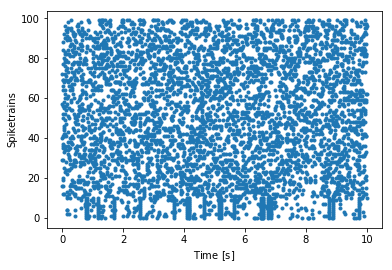

In [24]:
from plot_data import plot_data
plot_data('original_data/dataset2.nix', 'original_data/dataset2.png')

For the context of this analysis we teach snakemake how to go from arbitraty datasets in the nix format to a plot of the data. Now the exact data location of the nix file is not relevant any more since we introduced an additional `folder` wildcard.

In [25]:
%%writefile -a Snakefile

rule plot_data:
    input: '{folder}/dataset{id}.nix'
    output: '{folder}/dataset{id}.png'
    shell: 'python plot_data.py {input} {output}'

Appending to Snakefile


To let snakemake generate the overview plot of a dataset now we only need to request the corresponding png file:

In [26]:
%%sh
snakemake original_data/dataset0.png 

Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	plot_data
	1

[Fri Jun 28 11:42:17 2019]
rule plot_data:
    input: original_data/dataset0.nix
    output: original_data/dataset0.png
    jobid: 0
    wildcards: folder=original_data, id=0

[Fri Jun 28 11:42:22 2019]
Finished job 0.
1 of 1 steps (100%) done
Complete log: /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/.snakemake/log/2019-06-28T114217.354147.snakemake.log


### Running SPADE
In the next step we want to run an analysis on the data, which is detecting the injected higher order correlation in the data. One of the methods suited for the detection of spatio-temporal patterns is `SPADE` [(Quaglio et al, 2017)](https://doi.org/10.3389/fncom.2017.00041)
.

In [27]:
%%writefile run_spade.py
import sys
import numpy as np
import neo
import quantities as pq
import elephant.spade


def clean_nix_annotations(block):
    '''helper function needed for neo 0.7.1'''
    # removing unnessesary annotations to permit block to be saved again via nix
    objs = [block] + block.filter(data=True, container=True)
    for obj in objs:
        if 'nix_name' in obj.annotations:
            obj.annotations.pop('nix_name')
        if 'neo_name' in obj.annotations:
            obj.annotations.pop('neo_name')
    

def run_spade(data_filename, output_filename):
    # loading dataset
    with neo.io.get_io(data_filename, 'rw') as io:
        block = io.read_block()
    spiketrains = block.segments[0].spiketrains
    
    # run spade analysis
    patterns = elephant.spade.spade(
        data=spiketrains, binsize=1*pq.ms, winlen=1, dither=5*pq.ms,
        min_spikes=3, n_surr=10, psr_param=[0,0,3],
        output_format='patterns')['patterns']
    
    # convert first pattern into annotations of spiketrains
    # default: no spike belongs to any pattern
    for spiketrain in spiketrains:
        spiketrain.annotate(pattern=np.array([False]*len(spiketrain)))
        
    # convert first detected pattern to annotations of spiketrains
    for pattern_id, pattern in enumerate(patterns):
        neurons = pattern['neurons']
        times = pattern['times']
        lags = pattern['lags']
        for n, neuron in enumerate(neurons):
            if n == 0:
                pattern_times = times
            else:
                pattern_times = times + lags[n-1]
            for pattern_time in pattern_times:
                spike_idx = np.abs(spiketrains[neuron]-pattern_time).argmin()
                spiketrains[neuron].annotations['pattern'][spike_idx] = True

    # overwrite original neo file
    clean_nix_annotations(block)
    with neo.io.NixIO(output_filename, 'ow') as io2: 
        io2.write_block(block)
        
if __name__=='__main__':
    run_spade(*sys.argv[1:])

Writing run_spade.py


We add a rule to the snakemake workflow for runnig spade:

In [28]:
%%writefile -a Snakefile

rule run_spade:
    input: 'original_data/dataset{id}.nix'
    output: 'results/dataset{id}.nix'
    shell: 'python run_spade.py {input} {output}'

Appending to Snakefile


Now we can run spade by simply requesting the analysis result file from snakemake

In [29]:
%%sh
snakemake results/dataset0.nix

Time for pvalue spectrum computation: 4.106586933135986
Time for data mining: 0.26384735107421875


Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	run_spade
	1

[Fri Jun 28 11:42:28 2019]
rule run_spade:
    input: original_data/dataset0.nix
    output: results/dataset0.nix
    jobid: 0
    wildcards: id=0

[Fri Jun 28 11:42:37 2019]
Finished job 0.
1 of 1 steps (100%) done
Complete log: /home/julia/presentations/2019-06-20_Toronto/snakemake_elephant_demo/.snakemake/log/2019-06-28T114228.075043.snakemake.log


## Apply analysis to experimental data <img src=https://web.gin.g-node.org/img/favicon.png alt="GIN" style="width: 100px;"/>
In the next step we want to apply the same workflow to a set of experimental data. The data are publicly available at the data hosting platform [GIN](https://web.gin.g-node.org/) and are described in detail in [Brochier (2018)](https://doi.org/10.1038/sdata.2018.55). We are going to download two specific files of the dataset, which are saved in BlackRock nev/ns2 format. Since Neo also supports BlackRock formats, we use it to extract the relevant data and save them in the nix format to be consistent with the simulated data.

In [30]:
%%writefile convert_to_nix.py
import sys
import neo
import quantities as pq

def convert_data_to_nix(input_filename, nix_filename):
    print(input_filename)
    '''extracting first seconds of first spiketrains into separate nix file''' 
    io = neo.io.BlackrockIO(input_filename)
    original_block = io.read_block()
    
    # Extracting spiketrain and append to new block
    block = neo.Block(experiment='monkey')
    block.segments.append(neo.Segment(name='first seconds of recording'))
    new_spiketrains = [st.time_slice(0*pq.s,10*pq.s) for st in original_block.segments[-1].spiketrains[:100]]
    block.segments[0].spiketrains = new_spiketrains
    
    # save new block
    with neo.io.NixIO(nix_filename, 'ow') as io2:
        io2.write_block(block)
        
if __name__=='__main__':
    convert_data_to_nix(*sys.argv[1:])

Writing convert_to_nix.py


For fetching the data we directly download the data using `wget`. A more elegant version would involve installation of `git annex` or the `gin` client to be consistent with the version management handled by gin. We also add a generic rule which permits the conversion of BlackRock files to nix files while cropping only a selection of the data. The final rule `run_complete` requests visualizations of all analysis runs and therefore triggers the whole workflow.

In [31]:
%%writefile -a Snakefile

rule download_data:
    output:
        nev = 'original_data/dataset10.nev',
        ns2 = 'original_data/dataset10.ns2'
    shell: '''
    wget -O {output.nev} https://web.gin.g-node.org/INT/multielectrode_grasp/raw/24cd5caee3ae79066ca37844cab931d04dcad977/datasets/i140703-001-03.nev
    wget -O {output.ns2} https://web.gin.g-node.org/INT/multielectrode_grasp/raw/24cd5caee3ae79066ca37844cab931d04dcad977/datasets/i140703-001.ns2
    '''
        
rule convert_to_nix:
    input: '{filename}.nev',
           '{filename}.ns2'
    output: '{filename}.nix'
    shell: 'python convert_to_nix.py {wildcards.filename} {output}'
        
rule run_complete:
    input: expand('results/dataset{id}.png', id=range(11))

Appending to Snakefile


Running the complete workflow for the first time will take some time since the dataset is downloaded from the server. For subsequent runs, this should take much less time. 

In [32]:
%%sh
snakemake run_complete

Time for pvalue spectrum computation: 4.970012664794922
Time for data mining: 0.2785530090332031
Time for pvalue spectrum computation: 4.267902612686157
Time for data mining: 0.2734549045562744
Time for pvalue spectrum computation: 4.981806516647339
Time for data mining: 0.28731608390808105
Time for pvalue spectrum computation: 4.322018146514893
Time for data mining: 0.265500545501709
Time for pvalue spectrum computation: 4.989850044250488
Time for data mining: 0.32538747787475586
Time for pvalue spectrum computation: 4.284359455108643
Time for data mining: 0.28769493103027344
Time for pvalue spectrum computation: 4.309020042419434
Time for data mining: 0.30320143699645996
Time for pvalue spectrum computation: 4.38955545425415
Time for data mining: 0.2456526756286621
Time for pvalue spectrum computation: 4.546320199966431
Time for data mining: 0.25876426696777344
original_data/dataset10
Time for pvalue spectrum computation: 4.635357618331909
Time for data mining: 0.30143094062805176


Building DAG of jobs...
Using shell: /bin/bash
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	1	convert_to_nix
	1	download_data
	11	plot_data
	1	run_complete
	10	run_spade
	24

[Fri Jun 28 11:42:47 2019]
rule plot_data:
    input: results/dataset0.nix
    output: results/dataset0.png
    jobid: 1
    wildcards: folder=results, id=0

[Fri Jun 28 11:42:51 2019]
Finished job 1.
1 of 24 steps (4%) done

[Fri Jun 28 11:42:51 2019]
rule run_spade:
    input: original_data/dataset6.nix
    output: results/dataset6.nix
    jobid: 18
    wildcards: id=6

[Fri Jun 28 11:43:01 2019]
Finished job 18.
2 of 24 steps (8%) done

[Fri Jun 28 11:43:01 2019]
rule plot_data:
    input: results/dataset6.nix
    output: results/dataset6.png
    jobid: 7
    wildcards: folder=results, id=6

[Fri Jun 28 11:43:05 2019]
Finished job 7.
3 of 24 steps (12%) done

[Fri Jun 28 11:43:05 2019]
rule run_spade:
    input: original_data/dataset7.nix
    output: results/datase

The whole workflow encompasses now artificial data generation as well as retrieval of experimental data as well as a common analysis and visualization.

In [33]:
%%sh
snakemake run_complete --dag | dot | display
snakemake run_complete --dag | dot -Tsvg > run_complete.svg

Building DAG of jobs...
Building DAG of jobs...


![DAG](run_complete.svg)

Finally we can compare the results obtained based on the generated data to the experimental data.

### Artificial Data ![Plot1](results/dataset0.png)
### Experimental Data ![Plot2](results/dataset10.png)

Here you can see, that for the selected parameters SPADE detected a pattern in the generated data, which was not introduced in the data generation process. The detection of false patterns like this highly depends on the number of surrogates used for significance estimation. Here only 10 surrogates were used, which is leads to a number of false positives. In general detected spatiotemporal patterns should always be related to other events the experiment, e.g. by relating them to the behaviour of the subject.